# 1. Imports and load data


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("materials_final_with_price.csv")

print("Loaded dataset shape:", df.shape)
df.head()

Loaded dataset shape: (2456, 34)


,Material Name,Categories,Density,Chemical Properties,Mechanical Properties,Modulus of Elasticity,Poissons Ratio,Shear Modulus,Electrical Properties,Volume Resistivity,...,tk100(°C),"Maximum Service Temperature, Air",CaO+MgO,SiO2,Classification Temperature (°C),CategoryList,CO2_kg_per_kg,Recyclability_pct,Cost_INR_per_kg,Cost_per_CO2
0,Schott Glass 8347 Borosilicate Glass,Ceramic;Glass,2.230000,137.566437,804.229182,6.300000e+01,2.000000e-01,2.630000e+01,4.428196e+11,3.200000e+06,...,2.500000e+02,5.121166e+12,10325.090351,7.033929e+12,6.549217e+12,"['Ceramic', 'Glass']",2.225,11.25,160.0,71.910112
1,Morgan Advanced Ceramics Superwool® Plus Tank ...,Ceramic;Oxide,52.564922,159.711310,676.244252,6.855663e+07,7.506164e+10,1.469082e+06,4.665265e+11,9.633934e+11,...,5.589539e+12,1.000000e+03,5175.057844,8.037134e+12,1.200000e+03,"['Ceramic', 'Oxide']",2.550,5.00,200.0,78.431373
2,Hafnium,Metal;Nonferrous Metal;Pure Element,13.310000,28.074521,113.000000,1.898100e-01,1.300000e+00,7.800000e-01,5.423506e+00,4.500000e+02,...,1.000000e+02,1.000000e+02,164.149853,2.718212e+02,2.988681e+02,"['Metal', 'Nonferrous Metal', 'Pure Element']",6.020,49.50,300.0,49.833887
3,Chosun Refractories HSC-18RA Dense and High-St...,Ceramic;Oxide;Aluminum Oxide,61.029983,156.028123,646.217517,8.430067e+07,7.046600e+10,1.639846e+06,4.038578e+11,9.101925e+11,...,4.489199e+12,4.469460e+12,4215.807298,2.400000e+01,2.400000e+01,"['Ceramic', 'Oxide', 'Aluminum Oxide']",2.580,5.00,205.0,79.457364
4,MarkeTech CWO (Cadmium tungstate,Ceramic;Oxide,7.900000,159.711310,676.244252,6.855663e+07,7.506164e+10,1.469082e+06,4.665265e+11,9.633934e+11,...,5.589539e+12,5.431605e+12,5175.057844,8.037134e+12,1.042579e+13,"['Ceramic', 'Oxide']",2.550,5.00,200.0,78.431373


# 2. Fixing any problems

In [13]:
def split_categories(x):
    if pd.isna(x):
        return []
    return [c.strip() for c in str(x).split(";")]

df["Category_List"] = df["CategoryList"].apply(split_categories)

df = df.drop(columns=["CategoryList"])

non_numeric = ["Material Name", "Category_List"]
numeric_cols = [c for c in df.columns if c not in non_numeric]
df_num = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

numeric_cols = df_num.columns.tolist()

imp = SimpleImputer(strategy="median")
df_num_imputed = pd.DataFrame(imp.fit_transform(df_num), columns=numeric_cols)

df_clean = pd.concat([df[["Material Name", "Category_List"]], df_num_imputed], axis=1)

print("After imputation:", df_clean.shape)

After imputation: (2456, 33)


# 4. Scaling

In [14]:
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df_num_imputed)
df_scaled = pd.DataFrame(scaled_values, columns=numeric_cols)
df_scaled["Material Name"] = df_clean["Material Name"].values
df_scaled["Category_List"] = df_clean["Category_List"].values

# 5. PCA Visualization

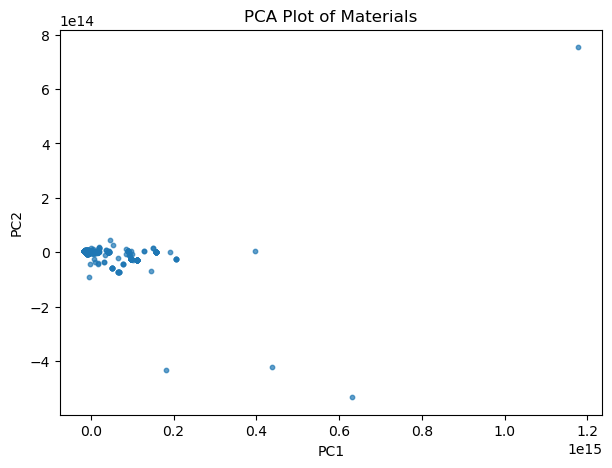

In [15]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(df_num_imputed)

plt.figure(figsize=(7,5))
plt.scatter(pca_2d[:,0], pca_2d[:,1], s=10, alpha=0.7)
plt.title("PCA Plot of Materials")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 6. Weights

In [16]:
weights = { 
    "Elastic Modulus": 0.20,
    "UTS": 0.20,
    "Yield Strength": 0.15,
    "Thermal Conductivity": 0.15,
    "Density": -0.10,        
    "CTE (Linear)": -0.10,
    "Specific_Stiffness": 0.10,
    "Strength_to_Weight": 0.10,
}

weight_vector = np.array([weights.get(c, 0.05) for c in num_cols])
weight_vector = weight_vector / weight_vector.sum()

weighted_score = (scaled * weight_vector).sum(axis=1)
df["Engineering_Score"] = weighted_score

# 7. Clustering

In [17]:
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(df_num_imputed)
df_scaled["Cluster"] = clusters

c:\Users\aayus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# 8. TOPIS Ranking

In [18]:
topsis_cols = [
    "UTS",
    "Elastic Modulus",
    "Strength_to_Weight",
    "Specific_Stiffness",
    "Thermal Conductivity",
    "Density",
    "Cost_USD_per_kg",
    "CO2_kg_per_kg"
]

topsis_cols = [c for c in topsis_cols if c in df_scaled.columns]

print("TOPSIS using columns:", topsis_cols)

X = df_scaled[topsis_cols].apply(pd.to_numeric, errors="coerce").values
X = SimpleImputer(strategy="median").fit_transform(X)

norm = np.linalg.norm(X, axis=0)
norm[norm == 0] = 1
R = X / norm

dirs = np.array([
    -1 if c in ["Density", "Cost_USD_per_kg", "CO2_kg_per_kg"] else 1
    for c in topsis_cols
])

weights = np.array([
    1.0 if c in ["UTS","Elastic Modulus","Strength_to_Weight","Specific_Stiffness"]
    else (0.9 if c=="Thermal Conductivity"
          else (0.8 if c in ["Cost_USD_per_kg","CO2_kg_per_kg"]
                else 0.6))
    for c in topsis_cols
])
weights = weights / weights.sum()

V = R * weights

ideal_best  = np.where(dirs==1, V.max(axis=0), V.min(axis=0))
ideal_worst = np.where(dirs==1, V.min(axis=0), V.max(axis=0))

d_pos = np.linalg.norm(V - ideal_best, axis=1)
d_neg = np.linalg.norm(V - ideal_worst, axis=1)

df_scaled["TOPSIS_score"] = d_neg / (d_pos + d_neg + 1e-12)

TOPSIS using columns: ['Thermal Conductivity', 'Density', 'CO2_kg_per_kg']


# 9. Final Ranking

In [19]:
ranking = df_scaled[["Material Name","TOPSIS_score"]].sort_values(
    "TOPSIS_score", ascending=False
)

ranking.to_csv("materials_ranked.csv", index=False)
df_scaled.to_csv("materials_scores_only.csv", index=False)

print("Saved:")
print(" - materials_ranked.csv")
print(" - materials_scores_only.csv")

Saved:
 - materials_ranked.csv
 - materials_scores_only.csv


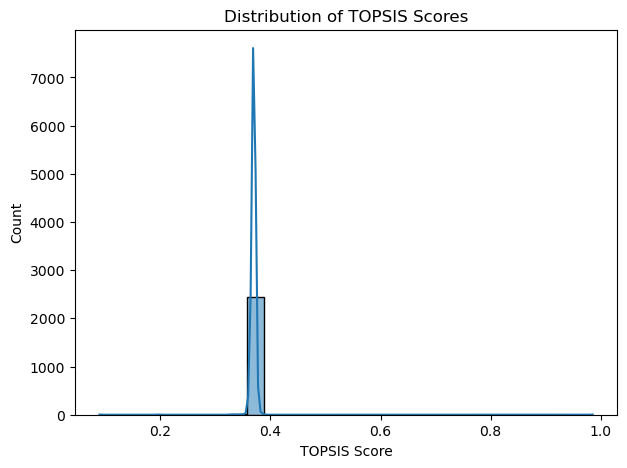

In [20]:
plt.figure(figsize=(7,5))
sns.histplot(df_scaled["TOPSIS_score"], bins=30, kde=True)
plt.title("Distribution of TOPSIS Scores")
plt.xlabel("TOPSIS Score")
plt.show()